In [ ]:
from google.colab import drive
#Data can be found here if you do not already own it: https://drive.google.com/drive/folders/1iyb8cPw-_7MJyH3rxiAb3K13NIpyzGs3?usp=sharing
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setting up the environment

!java -version

#Install Spark
#download file
!wget -q http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!pip install spotipy
#extract the file
!tar xf spark-3.3.1-bin-hadoop3.tgz
#install findspark package
!pip install -q findspark

openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 45.2 MB/s 
     |████████████████████████████████| 236 kB 62.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# 

import os
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("FinalProject").setMaster("local[*]")
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

In [ ]:
# Reading in the directory containing all the JSON files and storing them into
# Spark's RDD format

import time

Filepath = "/content/drive/MyDrive/BigData/Data/*.json"

start = time.time()

# df = spark.read.option("multiline", "true").json(Filepath)
df = spark.read.option("multiline","true").json(Filepath)
end = time.time()
total_time = end-start

print("took " + str(total_time) + " seconds")

took 24.172355890274048 seconds


In [ ]:
# Taking a look at the schema, we see that all of the headers were successfully imported and 
# we have all of the data we need to begin analyzing
#
# The format of the JSON files is deeply nested and so we only have two main columns:
# (1) info regarding the slice/part of the json files and when it was generated... info that is useless to us
# and (2) a column of playlists, which consists of rows of arrays, meaning each row contains multiple playlists
# 
# We will have to flatten and normalize this dataframe first before we can analyze the data

df.show(5)
df.printSchema()

+--------------------+--------------------+
|                info|           playlists|
+--------------------+--------------------+
|{2017-12-03 08:41...|[{false, null, 53...|
|{2017-12-03 08:41...|[{true, null, 165...|
|{2017-12-03 08:41...|[{false, null, 18...|
|{2017-12-03 08:41...|[{false, null, 11...|
|{2017-12-03 08:41...|[{false, null, 16...|
+--------------------+--------------------+
only showing top 5 rows

root
 |-- info: struct (nullable = true)
 |    |-- generated_on: string (nullable = true)
 |    |-- slice: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- playlists: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- collaborative: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- modified_at: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- num_albums: long (nullable = true)
 |    |  

In [ ]:
from pyspark.sql import functions as F
# Here, we've removed the useless info column and exploded the array of playlists so that
# each playlist was it's own row. 
#
# To double check, we counted the number of rows (1,000,000 playlists)

df = df.select(F.explode(F.col("playlists")).alias("playlists"))
#df1.printSchema()
#df.show()
print("counting # of playlists...")
df.count()

counting # of playlists...


17000

In [ ]:
# Here we take the "playlists" column exploded from earlier and select every column to be mapped to its proper header
# 
# We can now work with the playlists data to analyze, calculate, and answer questions.

df = df.select("playlists.*") #TODO: change * to only columns that we need to speed up operation times
df.show(3)
df.printSchema()


+-------------+-----------+-----------+-----------+-------+----------+-----------+---------+-------------+----------+-----+--------------------+
|collaborative|description|duration_ms|modified_at|   name|num_albums|num_artists|num_edits|num_followers|num_tracks|  pid|              tracks|
+-------------+-----------+-----------+-----------+-------+----------+-----------+---------+-------------+----------+-----+--------------------+
|        false|       null|   53274726| 1501200000|    •••|       157|        114|       95|            4|       227|12000|[{Or Nah (feat. T...|
|        false|       null|    3404199| 1434153600|Nite...|        12|         11|        9|            1|        14|12001|[{The Piano Guys,...|
|         true|       null|   10800737| 1478822400|    SOS|        43|         40|       16|            1|        46|12002|[{Stories, spotif...|
+-------------+-----------+-----------+-----------+-------+----------+-----------+---------+-------------+----------+-----+-------

In [ ]:
topPlaylistsDF = df.orderBy(['num_followers'], ascending=[False])
topPlaylistsDF.show(5)

+-------------+--------------------+-----------+-----------+-----------+----------+-----------+---------+-------------+----------+-----+--------------------+
|collaborative|         description|duration_ms|modified_at|       name|num_albums|num_artists|num_edits|num_followers|num_tracks|  pid|              tracks|
+-------------+--------------------+-----------+-----------+-----------+----------+-----------+---------+-------------+----------+-----+--------------------+
|        false|All that pop good...|   11005740| 1501804800|    TOP POP|        46|         41|        2|        15842|        52| 7215|[{Fetish (feat. G...|
|        false|Each week we'll b...|   11765108| 1509321600|Now Playing|        47|         46|       14|         2699|        50| 2957|[{Baltimore (Sky ...|
|        false|                null|   15112167| 1499040000|    Tangled|        37|         59|       15|         1038|        81|  765|[{Tangled, spotif...|
|        false|                null|    4879225| 150

In [ ]:
# Here we isolate the tracks column, which has a lot of information about the tracks nested inside arrays
# we explode it and only select the columns that we are interested in looking at...

df_tracks = df.select("tracks")
df_tracks = df_tracks.select(F.explode(F.col("tracks")).alias("tracks"))
df_tracks = df_tracks.select("tracks.album_name", "tracks.artist_name", "tracks.track_name", "tracks.duration_ms", "tracks.track_uri")
#df_tracks = df_tracks.select("tracks.album_name", "tracks.artist_name", "tracks.track_name", "tracks.track_uri")
df_tracks.show(10)
df_tracks.count()

+--------------------+-------------+--------------------+-----------+--------------------+
|          album_name|  artist_name|          track_name|duration_ms|           track_uri|
+--------------------+-------------+--------------------+-----------+--------------------+
|Or Nah (feat. The...|Ty Dolla $ign|Or Nah (feat. The...|     242983|spotify:track:7t2...|
|             Trilogy|   The Weeknd|        Wicked Games|     323746|spotify:track:6Vw...|
|Mind Of Mine (Del...|         ZAYN|               wRoNg|     212746|spotify:track:7iC...|
|Mind Of Mine (Del...|         ZAYN|                 TiO|     178693|spotify:track:7jK...|
|If You're Reading...|        Drake|              Legend|     241853|spotify:track:1ID...|
|              Forbes|       G-Eazy|              Forbes|     206315|spotify:track:31R...|
|What A Time To Be...|        Drake|             Jumpman|     205879|spotify:track:27G...|
|           SremmLife| Rae Sremmurd|        Come Get Her|     212946|spotify:track:1Se...|

1130751

# Track Analysis
---

In [ ]:
 # Q1: Who were the most popular artists in 2010-2017 in users' playlists?

df_tracks.groupBy("artist_name").count().orderBy(['count'], ascending=[False]).show()

# TODO: Find % of playlists with drake, kanye or kendrick in them... this is just the count of how many times they appear

+-----------------+-----+
|      artist_name|count|
+-----------------+-----+
|            Drake|14043|
|       Kanye West| 6824|
|   Kendrick Lamar| 5670|
|          Rihanna| 5493|
|       The Weeknd| 5079|
|       Ed Sheeran| 4584|
|           Eminem| 4548|
|           Future| 4334|
|          Beyoncé| 4172|
| The Chainsmokers| 4047|
|          J. Cole| 3862|
|    Justin Bieber| 3719|
|      Chris Brown| 3488|
|Twenty One Pilots| 3428|
|     Lil Uzi Vert| 3396|
|    Calvin Harris| 3345|
|       Luke Bryan| 3332|
|         Maroon 5| 3291|
|         Big Sean| 3189|
|           G-Eazy| 3179|
+-----------------+-----+
only showing top 20 rows



,Song By Artist,count
0,HUMBLE. By Kendrick Lamar,772
1,Closer By The Chainsmokers,756
2,One Dance By Drake,699
3,Broccoli (feat. Lil Yachty) By DRAM,683
4,Congratulations By Post Malone,638
5,Caroline By Aminé,618
6,Bad and Boujee (feat. Lil Uzi Vert) By Migos,573
7,iSpy (feat. Lil Yachty) By KYLE,572
8,Roses By The Chainsmokers,566
9,XO TOUR Llif3 By Lil Uzi Vert,566


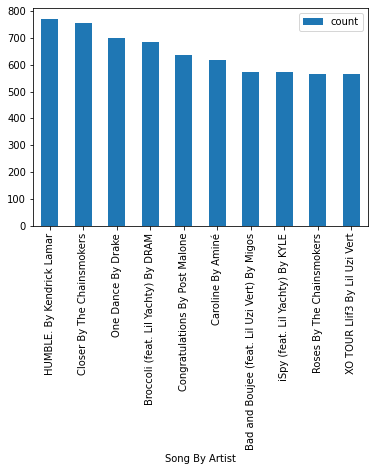

In [ ]:
# Q2: What were the most popular tracks in 2010-2017 in users' playlists?
from pyspark.sql.functions import concat,col,lit
#df_tracks.show()
################

###############
pandasPopTracks = df_tracks.select(concat(col("track_name"),lit(" By "), col("artist_name")).alias("Song By Artist")).groupBy("Song By Artist").count().orderBy(['count'], ascending=[False]).toPandas().head(10)
display(pandasPopTracks)
pandasPopTracks.plot(x="Song By Artist", y="count", kind="bar")

In [ ]:
# Q3: What is the average song duration? What is the longest song? Shortest?

# TODO: convert avg song to mm:ss
# TODO: filter -1/0 values from duration_ms
# TODO: investigate why max song is so high

df_tracks.select((F.avg("duration_ms")/60000).alias("Avg Song Duration"), \
                 (F.max("duration_ms")/60000).alias("Max Song Duration"), \
                 (F.min("duration_ms")/60000).alias("Min Song Duration")).show()

+-----------------+-----------------+-----------------+
|Avg Song Duration|Max Song Duration|Min Song Duration|
+-----------------+-----------------+-----------------+
|3.909505777148697|87.99613333333333|              0.0|
+-----------------+-----------------+-----------------+



# Playlist Analysis
---

In [ ]:
df_playlists = df.select("pid", "name", "description", "num_tracks", "num_artists", "num_albums", "duration_ms", "tracks")

,name,count
0,Country,631
1,Chill,474
2,Music,424
3,Summer,338
4,Songs,333
5,Rock,309
6,Good,297
7,Party,279
8,Playlist,271
9,Workout,247


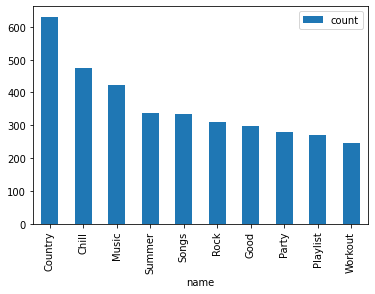

In [ ]:
# Q1: What is the most common word in the playlist name?

pandasPlaylists = df_playlists.withColumn('name', F.explode(F.split(F.initcap(F.col('name')), ' '))) \
  .where(F.col('name') != '') \
  .groupBy('name') \
  .count() \
  .sort('count', ascending=False)\
  .toPandas()
display(pandasPlaylists.head(10))

pandasPlaylists.head(10).plot(x="name", y="count", kind="bar")


  

In [ ]:
# Q2: What is the most common word in the playlist description?

df_playlists.withColumn('description', F.explode(F.split(F.col('description'), ' '))) \
  .groupBy('description') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-----------+-----+
|description|count|
+-----------+-----+
|        the|   65|
|         to|   55|
|         of|   51|
|        and|   44|
|          a|   41|
|      songs|   38|
|        you|   38|
|        for|   34|
|       that|   29|
|         in|   25|
|       this|   24|
|         is|   22|
|         :)|   22|
|          I|   20|
|       from|   18|
|          i|   18|
|         my|   17|
|   playlist|   16|
|       some|   16|
|         it|   16|
+-----------+-----+
only showing top 20 rows



In [ ]:
# The most common words are not really useful here in the description,
# So some filtering must be done to remove the common word and find common KEY words

# TODO: Add more filters or find a way to add values into array and filter by that

pl_clean_description = df_playlists.withColumn('words', F.explode(F.split(F.col('description'), ' '))) \
  .groupBy('words') \
  .count() \
  .filter((F.col("words") != "the") & (F.col("words") != "to") & (F.col("words") != " ") & (F.col("words") != "and") &\
          (F.col("words") != "of") & (F.col("words") != "a") & (F.col("words") != "for") & (F.col("words") != "you") &\
          (F.col("words") != "that") & (F.col("words") != "in") & (F.col("words") != "my") & (F.col("words") != "I") &\
          (F.col("words") != "is") & (F.col("words") != "this") & (F.col("words") != "i") & (F.col("words") != "your")&\
          (F.col("words") != "with") & (F.col("words") != "from") & (F.col("words") != "all") & (F.col("words") != "me")&\
          (F.col("words") != "some") & (F.col("words") != "on") & (F.col("words") != "when") & (F.col("words") != "it")&\
          (F.col("words") != "just") & (F.col("words") != "like") & (F.col("words") != "are") & (F.col("words") != "or")&\
          (F.col("words") != "The") & (F.col("words") != "be") & (F.col("words") != " ") & (F.col("words") != "A")&\
          (F.col("words") != "have") & (F.col("words") != "at") & (F.col("words") != "these") & (F.col("words") != "I") &\
          (F.col("words") != "that") & (F.col("words") != "in") & (F.col("words") != "my") & (F.col("words") != "I") &\
          (F.col("words") != "but") & (F.col("words") != "get") & (F.col("words") != "by") & (F.col("words") != "not")) \
  .sort('count', ascending=False) \
  
pl_clean_description.show()

+--------+-----+
|   words|count|
+--------+-----+
|   songs|   38|
|      :)|   22|
|playlist|   16|
|   music|   15|
|    love|   14|
|  listen|   14|
|     new|   10|
|    good|   10|
|    will|    9|
|    know|    9|
|        |    8|
|   Songs|    8|
|    best|    8|
|    make|    7|
|favorite|    7|
|      up|    7|
|      as|    7|
|   Music|    6|
|    This|    6|
|      am|    6|
+--------+-----+
only showing top 20 rows



In [ ]:
#list_of_genres = {"pop", "rock", "hip hop", "latin", "dance", "edm", "r&b", "country", "classical", "metal", "jazz"}

In [ ]:
# Q3: What is the average playlist duration? Is there a maximum duration to a playlist? min?

df_playlists.select((F.avg("duration_ms")/60000).alias("Avg Playlist Duration"), \
                    (F.max("duration_ms")/60000).alias("Max Playlist Duration"), \
                    (F.min("duration_ms")/60000).alias("Min Playlist Duration")).show()

+---------------------+---------------------+---------------------+
|Avg Playlist Duration|Max Playlist Duration|Min Playlist Duration|
+---------------------+---------------------+---------------------+
|   260.03985688333336|   1389.1788333333334|   11.996133333333333|
+---------------------+---------------------+---------------------+



In [ ]:
# Q4: What is the average playlist track number? Is there a maximum amount of tracks to a playlist? min?

df_playlists.select((F.avg("num_tracks")).alias("Avg Number of Tracks"), \
                    (F.max("num_tracks")).alias("Max Number of Tracks"), \
                    (F.min("num_tracks")).alias("Min Number of Tracks")).show()

+--------------------+--------------------+--------------------+
|Avg Number of Tracks|Max Number of Tracks|Min Number of Tracks|
+--------------------+--------------------+--------------------+
|   66.51476470588236|                 250|                   5|
+--------------------+--------------------+--------------------+



Music Recommendation

User Artists


,artist_name,count
0,Forever The Sickest Kids,2
1,Midtown,1
2,The Rocket Summer,1
3,Panic! At The Disco,1
4,Cobra Starship,1


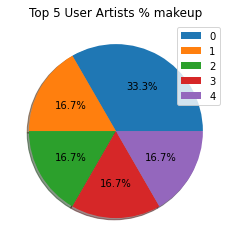

In [ ]:
#Q1: Who are some artists that the playlist user listens to?
from pyspark.sql.types import StructField, StructType, LongType, DataType, StringType, IntegerType, ArrayType
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

#Let's take a look at an individual user's playlist
dfprdd = df_playlists.rdd
sample = dfprdd.takeSample(False, 1, seed=None)
samplerdd = sc.parallelize(sample)
sampledf = samplerdd.toDF(schema=df_playlists.schema)
sampledDFTracks = sampledf.select("tracks")
sampledDFTracks = sampledDFTracks.select(F.explode(F.col("tracks")).alias("tracks"))
sampledDFTracks = sampledDFTracks.select("tracks.track_name" ,"tracks.artist_name")
#sampledDFTracks = sampledDFTracks.groupBy("track_name", "artist_name").count().drop(col("count"))
print("User Artists")
pandasSampleTracks = sampledDFTracks.groupBy(col("artist_name")).count().orderBy("count", ascending=False).toPandas()
display(pandasSampleTracks.head(5))
pandasSampleTracks.head(5).plot(x="artist_name", y="count", kind="pie", autopct='%1.1f%%', radius=1,shadow=True, legend=True, title='Top 5 User Artists % makeup', ylabel='', labeldistance=None)
plt.legend(loc='upper right')
plt.show()

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

auth_manager = SpotifyClientCredentials("96d4ef65e35f4943887b0d609f77ec05", "a51ead590a984d5a8513c0e344bb7400")
sp = spotipy.Spotify(auth_manager=auth_manager)
try:
  playlists = sp.user_playlists('12140909634')
  while playlists:
      for i, playlist in enumerate(playlists['items']):
          print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
      if playlists['next']:
          playlists = sp.next(playlists)
      else:
          playlists = None
except:
  print("idfk what happened, but it's probably a wrong UID")

inspectionPlaylistTracks = sp.playlist_tracks("3a6VpBua7fW7QP3B1sYKrI", additional_types=('track', ))
#print(inspectionPlaylistTracks)
songlist = []
for track in inspectionPlaylistTracks['items']:
  #print(track['track']['name'])
  try:
    specificTrack = track['track']
    specificArtist = specificTrack['album']['artists'][0]
    #print(specificTrack['name'])
    listitem = [specificTrack['name'],specificArtist['name'], specificArtist['id']]
    songlist.append(listitem)
  except:
    print("Something broke")
print(songlist)
songDF = sc.parallelize(songlist).toDF()#.groupBy('_3').count().orderBy(['count'], ascending=[False])
songDF.show()
top5 = songlist[0:5]
print(top5)
for song in top5:
  topSong= sp.artist_top_tracks(song[2])
  print(topSong)
  """
  for topSong in topSongs:
    print(topSong)
    specificTrack = topSong[0]
    print(specificTrack[0])
    
    specificArtist = specificTrack['album']
    topSongList = [specificTrack['name'],specificArtist['name']]
"""

   1 spotify:playlist:74iifDQ6WIHVcExHbM0j5w TEST
   2 spotify:playlist:4JmAyPNxFeiuWZVYOsmLTW ImANightmare
   3 spotify:playlist:6bpvF0R4rihBZzKVC9TcEU Drive.
   4 spotify:playlist:6QZAa2lnT75FAWtghPoFLH Menagerie Character Themes
   5 spotify:playlist:1WJIhOHbJTlnWwLz8mClhU Long Bus Running
   6 spotify:playlist:3gkenwxh1vx4M55MoCk8Mw Pokemon Hall of Fame
   7 spotify:playlist:0reoB0SdrhvxX9QsiPtMxK Christmas 2021
   8 spotify:playlist:6GP5UNyYLhfiUhp6uC0tAT One shot the party
   9 spotify:playlist:4lYJ6xEeb2usDj7sBrRp3l AJATT
  10 spotify:playlist:1t3yY3grArxrscK0DdX0km ROCK AND STONE
  11 spotify:playlist:4bB0z267Y2nYmDR8Lg1Ib1 Baking Cookies
  12 spotify:playlist:4IkMqGoi9YzWr9PHcO8WXA scone
  13 spotify:playlist:4Rtw85nzls2TZlX8g6WeQR You want a Metal?
  14 spotify:playlist:3GjIpyekGjkvRH6b0qU5ND Rap n Be
  15 spotify:playlist:3a6VpBua7fW7QP3B1sYKrI ROAD TRIP WITH ME
  16 spotify:playlist:6GnKsiNykJhpmkjP0IjFLu Road house
  17 spotify:playlist:5WHO2dq9a2vY5LSdcBCTAR Variety
  18 

In [ ]:
"""
This section is the beginning of the individual section of this final
Author: Eric Argenio
Date: 12/12/22
"""

#We'll start the recommendation by fetching some top songs from an artist we want to have more presence in our playlist. In this case, we'll start with King Gizzard
gizzardURL = "https://open.spotify.com/artist/6XYvaoDGE0VmRt83Jss9Sn?si=cMaz44BzT5CSVsU3RWMtdg"
gizzardTracks = sp.artist_top_tracks(gizzardURL)
print(gizzardTracks)
for track in gizzardTracks['tracks'][:10]:
    print(track['name'])
  #Spotify only allows us to get the top 10 tracks like this. Fortunately, each of these items comes with their URI. We will use this for the next step in our recommendations 

{'tracks': [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6XYvaoDGE0VmRt83Jss9Sn'}, 'href': 'https://api.spotify.com/v1/artists/6XYvaoDGE0VmRt83Jss9Sn', 'id': '6XYvaoDGE0VmRt83Jss9Sn', 'name': 'King Gizzard & The Lizard Wizard', 'type': 'artist', 'uri': 'spotify:artist:6XYvaoDGE0VmRt83Jss9Sn'}], 'external_urls': {'spotify': 'https://open.spotify.com/album/4tuqA7qbVsPukqsYPPrcF7'}, 'href': 'https://api.spotify.com/v1/albums/4tuqA7qbVsPukqsYPPrcF7', 'id': '4tuqA7qbVsPukqsYPPrcF7', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b27380c6db47e75d58e25b72f2ca', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e0280c6db47e75d58e25b72f2ca', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/ab67616d0000485180c6db47e75d58e25b72f2ca', 'width': 64}], 'name': 'Omnium Gatherum', 'release_date': '2022-04-22', 'release_date_precision': 'day', 'total_tracks': 16, 'type': 'album'

In [ ]:
#To make playlist creation easier for the user, we'll add a feature to automatically add items to a user playlist. In this case, we'll use my personal TEST playlist

import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

playlistURI = "74iifDQ6WIHVcExHbM0j5w"
#We will also need to compile a list of the songs we want to add. We'll use the tracks from King Gizzard again
playlistAdditions = []
for track in gizzardTracks['tracks'][:10]:
    playlistAdditions.append(track['uri'])
"""
This method is what would be used, but requires authentication which will not be put in the source code

sp.playlist_add_items(playlistURI, playlistAdditions, position=None)
"""
#this method puts in the top 10 tracks by King Gizzard into the playlist


'\nThis method is what would be used, but requires authentication which will not be put in the source code\n\nsp.playlist_add_items(playlistURI, playlistAdditions, position=None)\n'

In [ ]:
#in an app, we could potentially ask the user for specific tracks they want added
searchResult = sp.search(q="Magenta Mountain", type="track", limit=5)
for result in searchResult['tracks']['items']:
  print(result['name'] + " " + "By " + result['album']['artists'][0]['name'])
#You can try with the following
query = input("What song would you like to add?\n")
searchResult = sp.search(q=query, type="track", limit=5)
for result in searchResult['tracks']['items']:
  print(result['name'] + " " + "By " + result['album']['artists'][0]['name'])


Magenta Mountain By King Gizzard & The Lizard Wizard
Sure And Choice By Magenta Mountain Ducks
Magenta By Casiio
Magenta Mountains By Deepp C
Magenta By Hardanty
What song would you like to add?
Yung Gravy
Betty (Get Money) By Yung Gravy
C'est La Vie (with bbno$ & Rich Brian) By Yung Gravy
Mr. Clean By Yung Gravy
Gravy Train By Yung Gravy
oops! By Yung Gravy
